In [108]:
#Libraries
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
import numpy as np
import os
import cv2
import time
from random import randint
import SimpleITK as sitk

#CNN Libraries
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation, Conv2DTranspose, concatenate
from keras.layers.core import Dropout
import tensorflow as tf
# from tensorflow.keras.models import Model

#Visualisation Libraries
import plotly.graph_objects as go
import pydicom
import matplotlib.pyplot as plt

# Mask Creation Libraries
import trimesh
# import pyvista as pv
from PIL import Image
# from stl import mesh
from skimage import measure
from skimage.transform import resize


Height and Width of Single MRI Scan:  (512, 512)


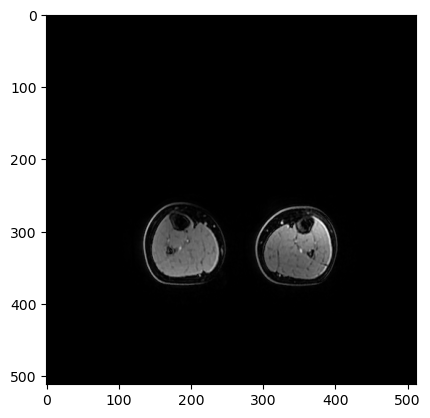

In [25]:
# Understanding the data format

# Read in Diacom file
example_mri_scan_file = pydicom.dcmread("D:/MRI - Tairawhiti/AutoBindWATER_450/IM-0046-0750.dcm")

# Assessing metadata within Diacom file
example_mri_scan = example_mri_scan_file.pixel_array

print('Height and Width of Single MRI Scan: ', example_mri_scan.shape)

plt.imshow(example_mri_scan, cmap='gray')
plt.show()

In [14]:
# %pip install trimesh
# %pip install mesh
# %pip install stl
# %pip install scipy
# %pip install opencv-python
# %pip install --upgrade numpy-stl

  Using cached stl-0.0.3-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


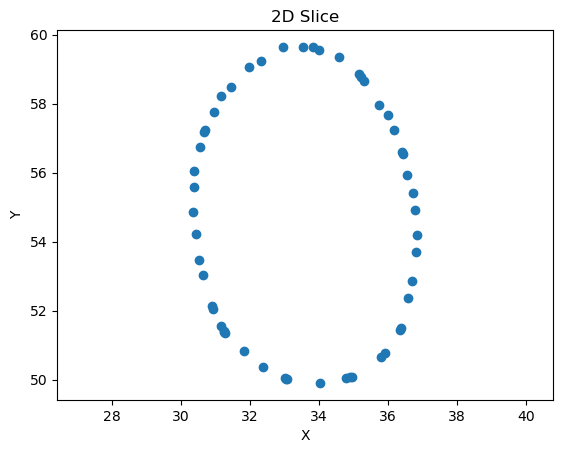

In [26]:
# Load the STL file
mesh = trimesh.load('C:/Users/GGPC/OneDrive/Desktop/Part 4 Project/Part4Project/SegmentationMasks/R_tibia_15A.stl')

thickness = 2.0

slice_data_all = []

z_min = mesh.bounds[0][2]
z_max = mesh.bounds[1][2]

# Create an array of z-values for the slices
z_values = np.arange(z_min, z_max, thickness)

for z in z_values:
    # Create a new 2D slice at the current z-coordinate
    plane_origin = [0, 0, z]
    plane_normal = [0, 0, 1]
    slice_mesh = mesh.section(plane_origin=plane_origin, plane_normal=plane_normal)

    if slice_mesh is not None:
        # Get the vertices of the slice and convert to numpy array
        slice_data = np.array(slice_mesh.vertices)
        slice_data_all.append(slice_data)

# Extract X, Y, and Z coordinates from slice_data
slice = 0
x_coords = (slice_data_all[slice])[:, 0]
y_coords = (slice_data_all[slice])[:, 1]
z_coords = (slice_data_all[slice])[:, 2]

# Plot the 2D slice
plt.figure()
plt.scatter(x_coords, y_coords)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Slice')
plt.axis('equal')
plt.show()

In [116]:
# Load the STL file
mesh = trimesh.load('C:/Users/GGPC/OneDrive/Desktop/Part 4 Project/Part4Project/SegmentationMasks/R_tibia_15A.stl')

# Will require tuning in future
voxel_size = 0.1

# Voxelization
# The first dimension (604): This dimension represents the size of the voxel array in the x-direction. It corresponds to the number of elements or voxels along the x-axis.
# The second dimension (541): This dimension represents the size of the voxel array in the y-direction. It corresponds to the number of elements or voxels along the y-axis.
# The third dimension (3152): This dimension represents the size of the voxel array in the z-direction. It corresponds to the number of elements or voxels along the z-axis. 
# The z-axis typically corresponds to the axial plane in medical imaging.
voxels = mesh.voxelized(pitch=voxel_size)
voxel_data = voxels.matrix.astype(np.uint8)



# Initialize empty arrays to store the resized data
new_size = (512, 512)
resized_voxel_data_2d = np.empty((new_size[0], new_size[1], voxel_data.shape[2]), dtype=voxel_data.dtype)
# Resize each 2D slice in the resized_voxel_data and resized_masks arrays
for i in range(voxel_data.shape[2]):
    resized_voxel_data_2d[:,:,i] = resize(voxel_data[:,:,i], new_size)


# Resizing Voxel Data
# One voxel is the slice size  
scans_z = 615
resizing_factor = scans_z / resized_voxel_data_2d.shape[2]
# Generate new z indices
indices = np.arange(0, resized_voxel_data_2d.shape[2], resizing_factor).astype(int)
# Resize the voxel_data array along the z dimension
resized_voxel_data = resized_voxel_data_2d[:, :, indices]


# Extract 2D slices along the desired axis (e.g., axial)
slice_index = 615
masks_tibia = []
for i in range (slice_index):
    slices = resized_voxel_data[:, :, i]  # Adjust the axis and slice index as needed
    masks = np.where(slices > 0, 1, 0)
    masks_tibia.append(masks)
masks_tibia = np.array(masks_tibia)

# for i in range (len(masks_tibia)):
#     img_resized = cv2.resize(masks_tibia[i], (512, 512))



In [79]:
haha = []
for i in range (len(voxel_data[0])):
    haha.append(np.mean(voxel_data[0][i]))

print(np.mean(haha))

0.003509781357882624


In [118]:
masks_tibia.shape

(615, 512, 512)

In [115]:
resized_voxel_data_2d.shape

(512, 512, 16155)

In [106]:
masks_tibia.shape

(615, 604, 541)

In [53]:
num_true = np.sum(voxels[-1][-1])
num_false = np.sum(~voxels[-1][-1])

print("Number of True values:", num_true)
print("Number of False values:", num_false)

Number of True values: 0
Number of False values: 320


In [48]:
voxels[0][0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,